<a href="https://colab.research.google.com/github/JuShiCode/JuShiCode/blob/main/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%82%D1%80%D0%B0%D1%84%D0%B8%D0%BA%D0%B0_%D1%81%D0%B0%D0%B9%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Загружаем библиотеки

In [ ]:
import pandas as pd #pandas
import numpy as np #numpy
import matplotlib.pyplot as plt #отрисовка графиков
%matplotlib inline

from tensorflow.keras import utils #для to_categorical
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #модели
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, LSTM #стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator #для генерации выборки временных рядов

#Загружаем данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_data = pd.read_csv('/content/drive/My Drive/Базы/traff.csv')
base_data.head()

,1/1/2017,"22,226.00"
0,1/2/2017,"29,593.00"
1,1/3/2017,"31,726.00"
2,1/4/2017,"32,684.00"
3,1/5/2017,"31,820.00"
4,1/6/2017,"29,354.00"


In [ ]:
# Убираем ненужную колонку с датой
base_data = base_data.iloc[:,1:]
base_data.columns = ['traff']
base_data.head()

,traff
0,"29,593.00"
1,"31,726.00"
2,"32,684.00"
3,"31,820.00"
4,"29,354.00"


In [ ]:
# Удаляем ненужный символ ','
a = []
for i in range(len(base_data)):
    
    a.append(float(base_data['traff'][i].replace(',','')))

In [ ]:
index = list(range(len(base_data)))
data = pd.DataFrame(a, columns = ['traff'], index = index)
data

,traff
0,29593.0
1,31726.0
2,32684.0
3,31820.0
4,29354.0
...,...
1089,29801.0
1090,34913.0
1091,37665.0
1092,32643.0


In [ ]:
data.shape

(1094, 1)

#Формируем выборки

In [ ]:
xLen = 60
valLen = 300 

trainLen = data.shape[0]-valLen 

xTrain,xTest = data[:trainLen], data[trainLen+xLen+2:]

xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yTrain,yTest = np.reshape(data[:trainLen],(-1,1)), np.reshape(data[trainLen+xLen+2:],(-1,1)) 
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

trainDataGen = TimeseriesGenerator(xTrain, yTrain, 
                               length=xLen, sampling_rate=1, 
                               batch_size=20)                

testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=20)

In [ ]:
print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)
print(trainDataGen[0][0].shape)
# print(testDataGen.shape)

(794, 1)
(238, 1)
(794, 1)
(238, 1)
(20, 60, 1)


# Визуализация результатов

In [ ]:
def getPred(currModel, xVal, yVal, yScaler):

  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()
  
def correlate(a, b):

  ma = a.mean() 
  mb = b.mean()
  mab = (a*b).mean() 
  sa = a.std() 
  sb = b.std() 
  
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

def showCorr(channels, corrSteps, predVal, yValUnscaled):
  for ch in channels:
    corr = []
    yLen = yValUnscaled.shape[0] 
    for i in range(corrSteps):
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] 

    for i in range(corrSteps):
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.show()

DataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, sampling_rate=1,
                               batch_size=len(xTest))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

# Нейронная сеть

Epoch 1/10
37/37 [==============================] - 18s 40ms/step - loss: 13.9019 - val_loss: 1.9164
Epoch 2/10
37/37 [==============================] - 1s 29ms/step - loss: 0.7091 - val_loss: 0.0138
Epoch 3/10
37/37 [==============================] - 1s 29ms/step - loss: 0.0561 - val_loss: 0.0721
Epoch 4/10
37/37 [==============================] - 1s 29ms/step - loss: 0.0265 - val_loss: 0.0073
Epoch 5/10
37/37 [==============================] - 1s 29ms/step - loss: 0.0104 - val_loss: 0.0051
Epoch 6/10
37/37 [==============================] - 1s 29ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 7/10
37/37 [==============================] - 1s 29ms/step - loss: 0.0066 - val_loss: 0.0049
Epoch 8/10
37/37 [==============================] - 1s 29ms/step - loss: 0.0079 - val_loss: 0.0043
Epoch 9/10
37/37 [==============================] - 1s 29ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 10/10
37/37 [==============================] - 1s 29ms/step - loss: 0.0035 - val_loss: 0.0047


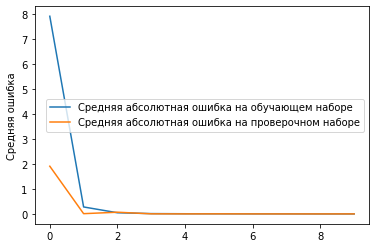

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(2048, 5, input_shape = (xLen,1), activation='linear'))
modelC.add(Flatten())
modelC.add(Dense(2048, activation='linear'))
modelC.add(Dense(1, activation='linear'))

modelC.compile(loss='mse', optimizer=Adam(lr=1e-4))

history = modelC.fit(trainDataGen,
                    epochs=10, verbose=1,
                    validation_data=testDataGen)

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

#Результат работы сети

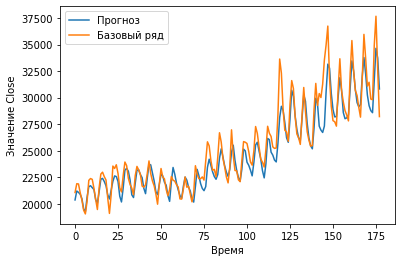

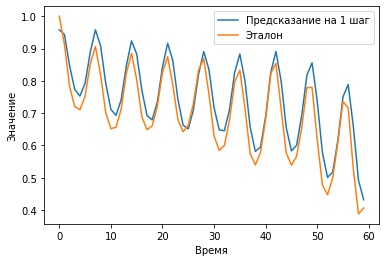

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)

showPredict(0, 4000, 0, predVal, yValUnscaled)

showCorr([0], 60, predVal, yValUnscaled)